<!-- html image label "fig:explainer" -->
<img src="figure/image1.gif" alt="Explainer" width="800">

In [1]:
# jupyter lab --port=44000 --ip=$HOSTNAME --no-browser

import os
jobID = os.getenv('LSB_JOBID')
host = os.getenv('HOSTNAME')
os.environ['CUDA_VISIBLE_DEVICES'] = '1,3'
!echo $CUDA_VISIBLE_DEVICES
!echo $HOSTNAME
!echo $LSB_JOBID
# !nvidia-smi

1,3


t1v-n-4a71229d-w-0



In [4]:
import mujoco
import jax
import brax
from jax import numpy as jp
from matplotlib import rc
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from brax.io import mjcf
import mediapy as media
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
rc('animation', html='jshtml')
%env MUJOCO_GL=egl

tpu
env: MUJOCO_GL=egl


In [7]:
# Load the cartpole environment from file
path = f'/work3/s213120/whipping_brax/xml/scene_torque.xml'
mj = mujoco.MjModel.from_xml_path(path)
# change the intergrator from implicit to euler
if mj.opt.integrator != 0:
    print("Brax 目前只支持Euler intergrator")
    mj.opt.integrator = 0

# Barx 目前只支持球形碰撞体, 令mj.geom_contype[i]和mj.geom_conaffinity[i]=0
print("Brax 目前只支持球形碰撞体, 令mj.geom_contype[i]和mj.geom_conaffinity[i]=0")
for i, typ in enumerate(mj.geom_type):
    if typ == 5: # cylinder
        mj.geom_contype[i] = 0
        mj.geom_conaffinity[i] = 0

model = mjcf.load_model(mj)

Brax 目前只支持Euler intergrator
Brax 目前只支持球形碰撞体, 令mj.geom_contype[i]和mj.geom_conaffinity[i]=0


### Whip-Arm-Target

In [3]:
path = f'env/whip_1.xml'
mj = mujoco.MjModel.from_xml_path(path)
sys = mjcf.load_model(mj)

In [13]:
sys.q_size(), sys.init_q.shape[0], sys.qd_size()

(64, 64, 63)

#### Link

In [14]:
sys.num_links(), sys.link_types, len(sys.link_types)

(33, '11111112222222222222222222222222f', 33)

In [15]:
len(sys.dof_ranges()), len(sys.geoms)

(33, 5)

In [16]:
len(sys.link_names), len(sys.link_parents), len(sys.dof_ranges())

(33, 33, 33)

In [17]:
list(zip(sys.link_names, sys.link_parents, sys.link_types, sys.dof_ranges()))

[('link1', -1, '1', [0]),
 ('link2', 0, '1', [1]),
 ('link3', 1, '1', [2]),
 ('link4', 2, '1', [3]),
 ('link5', 3, '1', [4]),
 ('link6', 4, '1', [5]),
 ('link7', 5, '1', [6]),
 ('B0', 6, '2', [7, 8]),
 ('B1', 7, '2', [9, 10]),
 ('B2', 8, '2', [11, 12]),
 ('B3', 9, '2', [13, 14]),
 ('B4', 10, '2', [15, 16]),
 ('B5', 11, '2', [17, 18]),
 ('B6', 12, '2', [19, 20]),
 ('B7', 13, '2', [21, 22]),
 ('B8', 14, '2', [23, 24]),
 ('B9', 15, '2', [25, 26]),
 ('B10', 16, '2', [27, 28]),
 ('B11', 17, '2', [29, 30]),
 ('B12', 18, '2', [31, 32]),
 ('B13', 19, '2', [33, 34]),
 ('B14', 20, '2', [35, 36]),
 ('B15', 21, '2', [37, 38]),
 ('B16', 22, '2', [39, 40]),
 ('B17', 23, '2', [41, 42]),
 ('B18', 24, '2', [43, 44]),
 ('B19', 25, '2', [45, 46]),
 ('B20', 26, '2', [47, 48]),
 ('B21', 27, '2', [49, 50]),
 ('B22', 28, '2', [51, 52]),
 ('B23', 29, '2', [53, 54]),
 ('B24', 30, '2', [55, 56]),
 ('target', -1, 'f', [57, 58, 59, 60, 61, 62])]

#### DoF

In [18]:
display(sys.q_idx("1")) # 7dof: 7joints
display(sys.q_idx("2")) # 50dof: 25joints
display(sys.q_idx("f")) # 6dof: 1joint

Array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

Array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56],      dtype=int32)

Array([57, 58, 59, 60, 61, 62, 63], dtype=int32)

In [22]:
display(sys.qd_idx("1")) # 7dof: 7joints
display(sys.qd_idx("2")) # 50dof: 25joints
display(sys.qd_idx("f")) # 6dof: 1joint
len(sys.qd_idx("2"))

Array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

Array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56],      dtype=int32)

Array([57, 58, 59, 60, 61, 62], dtype=int32)

50

### Visualize the model

In [5]:
from brax.generalized import pipeline
from brax import kinematics

path = f'env/whip_1.xml'
mj = mujoco.MjModel.from_xml_path(path)
sys = mjcf.load_model(mj)

q = sys.init_q
qd = jp.zeros(sys.qd_size())
x, xd = kinematics.forward(sys, q, qd)
state = jax.jit(pipeline.init)(sys, q, qd)

In [6]:
state.x.pos.all() == x.pos.all(), x.pos.shape

(Array(True, dtype=bool), (33, 3))

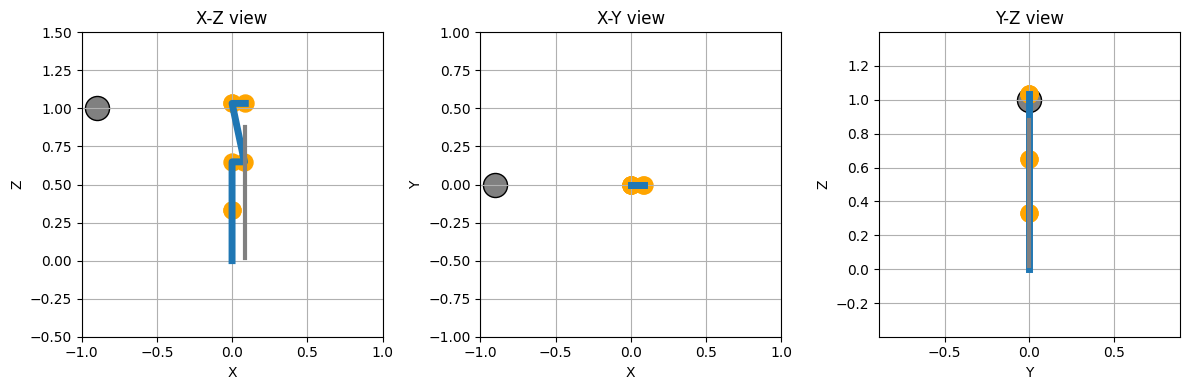

In [7]:
def visualize(axes, pos, alpha=1):
    assert axes.shape == (3,)
    x_arm = jp.vstack([jp.zeros((1,3)), pos[:7]])
    joint_names = ['jnt-1', 'jnt-2', 'jnt-3', 'jnt-4', 'jnt-5', 'jnt-6', 'jnt-7']
    title = ['X-Z view', 'X-Y view', 'Y-Z view']
    xlim = [(-1, 1), (-1, 1), (-1, 1)]
    ylim = [(-0.5, 1.5), (-1, 1), (-0.5, 1.5)]
    for i in range(3):
        axes[i].plot(x_arm[:, i//2], x_arm[:, 2-i%2], linewidth=5, label='Arm', alpha=alpha)
        axes[i].plot(pos[7:-1, i//2], pos[7:-1, 2-i%2], linewidth=3, color='gray', label='Whip', alpha=alpha)
        axes[i].scatter(pos[-1, i//2], pos[-1, 2-i%2], s=300, c='gray', edgecolors='black', label='Target', alpha=alpha)
        axes[i].scatter(pos[:7, i//2], pos[:7, 2-i%2], s=150, c='orange', edgecolors='face', label='Joint')
        axes[i].grid()
        axes[i].set_title(title[i])
        axes[i].set_xlabel(title[i][0:1])
        axes[i].set_ylabel(title[i][2:3])
        axes[i].set_xlim(*xlim[i])
        axes[i].set_ylim(*ylim[i])
    legend = axes[-1].legend(['Arm', 'Whip', 'Target'], loc='upper right', title='Components', bbox_to_anchor=(1.4, 1))
    axes[-1].add_artist(legend)

_, axes = plt.subplots(1,3, figsize=(12, 4))
plt.axis ('equal')
visualize(axes, x.pos, alpha=1)
plt.tight_layout()

In [8]:
def _random_target(rng: jp.ndarray):
    """Returns a target location and velocity."""
    mocap = jp.load('env/mocap.npy')
    rngs = jax.random.split(rng, 5)
    # target position and velocity
    mp_idx = jax.random.randint(rngs[1], (1,), 0, mocap.shape[1]-250)[0]
    pos_offset = 0.05 * jax.random.uniform(rngs[2], (3,), minval=-1, maxval=1)    
    vel_offset = 0.05 * jax.random.uniform(rngs[3], (3,), minval=-1, maxval=1)
    ang_offset = jp.pi / 36 * jax.random.uniform(rngs[3], (1,), minval=-1, maxval=1)[0]
    q_pos = mocap[mp_idx, 1:4] + pos_offset
    _, y_vel, z_vel = mocap[mp_idx, 4:] + vel_offset
    x_vel, y_vel = jp.sin(ang_offset) * y_vel, jp.cos(ang_offset) * y_vel
    q_vel = jp.array([x_vel, y_vel, z_vel])

    return rng, q_pos, q_vel

### Update Model

In [24]:
from brax import actuator
from brax import geometry
from brax import kinematics
from brax.base import System
from brax.generalized import constraint
from brax.generalized import dynamics
from brax.generalized import integrator
from brax.generalized import mass
from brax.generalized.base import State

In [34]:
path = f'env/whip_0.xml'
mj = mujoco.MjModel.from_xml_path(path)
sys = mjcf.load_model(mj)

In [35]:
rng = jax.random.PRNGKey(0)
_, q_pos, q_vel = _random_target(rng)
act = jp.zeros((7,))

q = sys.init_q
q = q.at[-7:-4].set(q_pos)
qd = jp.zeros(sys.qd_size())
qd = qd.at[-6:-3].set(q_vel)
state = jax.jit(pipeline.init)(sys, q, qd)

In [36]:
tau = actuator.to_tau(sys, act, state.q, state.qd)
tau

Array([  0.,   0.,   0., -87.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [37]:
qf_smooth = dynamics.forward(sys, state, tau)
state = state.replace(qf_smooth=qf_smooth)
qf_smooth

Array([ 0.0000000e+00,  3.6934159e+00,  0.0000000e+00, -8.3758965e+01,
        0.0000000e+00, -1.9532003e+00,  0.0000000e+00, -1.1175871e-08,
        1.1920929e-07, -9.3132257e-09,  1.0430813e-07, -7.4505806e-09,
        8.9406967e-08, -5.5879354e-09,  7.4505806e-08, -3.7252903e-09,
        5.9604645e-08, -3.7252903e-09,  4.4703484e-08, -9.3132257e-10,
        2.9802322e-08, -9.3132257e-10,  1.4901161e-08,  0.0000000e+00,
        0.0000000e+00,  9.3132257e-10,  0.0000000e+00,  9.3132257e-10,
        0.0000000e+00,  9.3132257e-10,  0.0000000e+00,  9.3132257e-10,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  4.6566129e-10,
        0.0000000e+00,  4.6566129e-10,  0.0000000e+00,  4.6566129e-10,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  1.8626451e-09, -2.3283064e-10,
        1.8626451e-09,  0.0000000e+00,  9.3132257e-10,  0.0000000e+00,
      

In [38]:
qf_constraint=constraint.force(sys, state)
state = state.replace(qf_constraint=qf_constraint)
qf_constraint

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float32)

In [39]:
state = integrator.integrate(sys, state)
state

State(q=Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float32), qd=Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float32), x=Transform(pos=Array([[ 0.0000000e+00,  0.0000000e+00,  3.3300000e-01],
       [ 0.0000000e+00,  0.0000000e+00,  3.3300000e-01],
       [ 0.0000000e+00,  0.0000000e+00,  6.4899999e-01],
       [ 8.2499996e-02,  0.0000000e+00,  6.4899999e-0

In [ ]:
tau = actuator.to_tau(sys, act, state.q, state.qd)
state = state.replace(qf_smooth=dynamics.forward(sys, state, tau))
state = state.replace(qf_constraint=constraint.force(sys, state))

# update position/velocity level terms
state = integrator.integrate(sys, state)
x, xd = kinematics.forward(sys, state.q, state.qd)
state = state.replace(x=x, xd=xd)
state = dynamics.transform_com(sys, state)
state = mass.matrix_inv(sys, state, sys.matrix_inv_iterations)
state = constraint.jacobian(sys, state)

In [16]:
state = jax.jit(pipeline.step)(sys, state, ctrl)

In [17]:
state.x.pos[-1,:]

Array([nan, nan, nan], dtype=float32)

In [25]:
force_range = jp.array([[-87, 87 ]]*4 + [[-12, 12]]*3)
ctrl_range = jp.array([[-2.8973,  2.8973], [-1.7628,  1.7628], [-2.8973,  2.8973], [-3.0718, -0.0698], [-2.8973,  2.8973], [-0.0175,  3.7525], [-2.8973,  2.8973]])
sys.actuator.replace(ctrl_range=ctrl_range)

Actuator(q_id=Array([0, 1, 2, 3, 4, 5, 6], dtype=int32), qd_id=Array([0, 1, 2, 3, 4, 5, 6], dtype=int32), ctrl_range=Array([[-2.8973,  2.8973],
       [-1.7628,  1.7628],
       [-2.8973,  2.8973],
       [-3.0718, -0.0698],
       [-2.8973,  2.8973],
       [-0.0175,  3.7525],
       [-2.8973,  2.8973]], dtype=float32), gear=Array([1., 1., 1., 1., 1., 1., 1.], dtype=float32), bias_q=Array([-4500., -4500., -3500., -3500., -2000., -2000., -2000.], dtype=float32), bias_qd=Array([-450., -450., -350., -350., -200., -200., -200.], dtype=float32))

In [16]:
sys.actuator.ctrl_range

Array([[-2.8973,  2.8973],
       [-1.7628,  1.7628],
       [-2.8973,  2.8973],
       [-3.0718, -0.0698],
       [-2.8973,  2.8973],
       [-0.0175,  3.7525],
       [-2.8973,  2.8973]], dtype=float32)

In [21]:
sys.actuator.__dict__.keys()

dict_keys(['q_id', 'qd_id', 'ctrl_range', 'gear', 'bias_q', 'bias_qd'])

In [127]:
x.pos.shape, xd.ang.shape

((36, 3), (36, 3))

[[-87, 87], [-87, 87], [-87, 87], [-87, 87], [-12, 12], [-12, 12], [-12, 12]]